In [2]:
import yfinance
import pandas as pd
import numpy as np

# fetch snp500 index data


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = "./data/USATECH.IDXUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv"

df = pd.read_csv(file_path)
df["Local time"] = df["Local time"].str.replace(r" GMT[+-]\d{4}", "", regex=True)

In [4]:
df["Local time"] = pd.to_datetime(df["Local time"], format="%d.%m.%Y %H:%M:%S.%f")

In [5]:
df.rename(columns={"Local time": "Date"}, inplace=True)

In [6]:
snp500_data = df.resample("D", on="Date").agg(
    {"Open": "first", "High": "max", "Low": "min", "Close": "last", "Volume": "sum"}
)

In [7]:
snp500_data.reset_index(inplace=True)

In [8]:
# Sort the data by date
snp500_data.sort_values(by="Date", inplace=True)

# snp500_data.set_index('Date', inplace=True)

# Calculate key technical indicators
snp500_data["SMA_20"] = snp500_data["Close"].rolling(window=20).mean()
snp500_data["SMA_50"] = snp500_data["Close"].rolling(window=50).mean()
snp500_data["MACD"] = (
    snp500_data["Close"].ewm(span=12, adjust=False).mean()
    - snp500_data["Close"].ewm(span=26, adjust=False).mean()
)
snp500_data["MACD_Signal"] = snp500_data["MACD"].ewm(span=9, adjust=False).mean()

snp500_data["ATR"] = (
    (snp500_data["High"] - snp500_data["Low"]).rolling(window=14).mean()
)


# RSI calculation
delta = snp500_data["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
snp500_data["RSI"] = 100 - (100 / (1 + rs))

# Bollinger Bands
snp500_data["BB_Middle"] = snp500_data["Close"].rolling(window=20).mean()
snp500_data["BB_Std"] = snp500_data["Close"].rolling(window=20).std()
snp500_data["BB_Upper"] = snp500_data["BB_Middle"] + (2 * snp500_data["BB_Std"])
snp500_data["BB_Lower"] = snp500_data["BB_Middle"] - (2 * snp500_data["BB_Std"])

# ADX calculation
snp500_data["TR"] = np.maximum(
    snp500_data["High"] - snp500_data["Low"],
    np.maximum(
        abs(snp500_data["High"] - snp500_data["Close"].shift(1)),
        abs(snp500_data["Low"] - snp500_data["Close"].shift(1)),
    ),
)

snp500_data["DMplus"] = np.where(
    (snp500_data["High"] - snp500_data["High"].shift(1))
    > (snp500_data["Low"].shift(1) - snp500_data["Low"]),
    np.maximum(snp500_data["High"] - snp500_data["High"].shift(1), 0),
    0,
)

snp500_data["DMminus"] = np.where(
    (snp500_data["Low"].shift(1) - snp500_data["Low"])
    > (snp500_data["High"] - snp500_data["High"].shift(1)),
    np.maximum(snp500_data["Low"].shift(1) - snp500_data["Low"], 0),
    0,
)

snp500_data["TR14"] = snp500_data["TR"].rolling(window=14).sum()

snp500_data["DMplus14"] = snp500_data["DMplus"].rolling(window=14).sum()

snp500_data["DMminus14"] = snp500_data["DMminus"].rolling(window=14).sum()

snp500_data["DIplus14"] = 100 * (snp500_data["DMplus14"] / snp500_data["TR14"])
snp500_data["DIminus14"] = 100 * (snp500_data["DMminus14"] / snp500_data["TR14"])
snp500_data["DX"] = 100 * (
    np.abs(snp500_data["DIplus14"] - snp500_data["DIminus14"])
    / (snp500_data["DIplus14"] + snp500_data["DIminus14"])
)
snp500_data["ADX"] = snp500_data["DX"].rolling(window=14).mean()

snp500_data.dropna(inplace=True)

print(snp500_data.columns)


# Adjusted refined signal generation function
def adjust_signals(
    data,
    rsi_oversold=30,
    rsi_overbought=70,
    bb_band=0.5,
    adx_threshold=25,
    buy_threshold=3,
    sell_threshold=4,
):
    # Individual conditions for Buy
    buy_conditions = [
        (data["RSI"] < rsi_oversold),  # Moderately oversold
        (data["SMA_20"] > data["SMA_50"]),  # Bullish crossover
        (data["MACD"] > data["MACD_Signal"]),  # MACD crossover
        (
            data["Close"]
            <= (data["BB_Lower"] + ((data["BB_Middle"] - data["BB_Lower"]) * bb_band))
        ),  # Near Bollinger Lower Band
        (data["ADX"] > adx_threshold),  # Trending market
    ]

    # Individual conditions for Sell
    sell_conditions = [
        (data["RSI"] > rsi_overbought),  # Moderately overbought
        (data["SMA_20"] < data["SMA_50"]),  # Bearish crossover
        (data["MACD"] < data["MACD_Signal"]),  # MACD crossover
        (
            data["Close"]
            >= (data["BB_Upper"] - ((data["BB_Upper"] - data["BB_Middle"]) * bb_band))
        ),  # Near Bollinger Upper Band
        (data["ADX"] > adx_threshold),  # Trending market
    ]

    # Buy/Sell signals if at least 2 conditions are true
    data["Buy_Signal"] = sum(buy_conditions)
    data["Sell_Signal"] = sum(sell_conditions)

    # print(data['Buy_Signal'].value_counts())
    # print(data['Sell_Signal'].value_counts())
    # print('\n-------------------\n')

    # drop overlapping signals (Buy and Sell at the same time)
    # if sum of buy signal is more than sell signal, then drop sell signal
    # if sum of sell signal is more than buy signal, then drop buy signal

    if data["Buy_Signal"].sum() > data["Sell_Signal"].sum():
        data.loc[data["Sell_Signal"] == 1, "Sell_Signal"] = 0

    elif data["Buy_Signal"].sum() < data["Sell_Signal"].sum():
        data.loc[data["Buy_Signal"] == 1, "Buy_Signal"] = 0

    # print(data['Buy_Signal'].value_counts())
    # print(data['Sell_Signal'].value_counts())

    # Generate final signals
    data["Adjusted_Signal"] = 0
    data.loc[data["Buy_Signal"] >= buy_threshold, "Adjusted_Signal"] = 1  # Buy signal
    data.loc[
        data["Sell_Signal"] >= sell_threshold, "Adjusted_Signal"
    ] = -1  # Sell signal

    return data


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'SMA_50',
       'MACD', 'MACD_Signal', 'ATR', 'RSI', 'BB_Middle', 'BB_Std', 'BB_Upper',
       'BB_Lower', 'TR', 'DMplus', 'DMminus', 'TR14', 'DMplus14', 'DMminus14',
       'DIplus14', 'DIminus14', 'DX', 'ADX'],
      dtype='object')


In [9]:
# Updated Backtesting Logic with Transaction Costs, Slippage, and ATR-based Stop Loss
def backtest_with_atr_stoploss(
    data,
    initial_capital=100000,
    transaction_cost=0.001,
    slippage=0.001,
    atr_multiplier=2,
):
    """
    Perform backtesting with transaction costs, slippage, and ATR-based stop loss.

    Parameters:
        data (pd.DataFrame): DataFrame with columns ['Close', 'ATR', 'Adjusted_Signal'].
        initial_capital (float): Starting capital for the backtest.
        transaction_cost (float): Proportional transaction cost per trade.
        slippage (float): Proportional slippage on each trade.
        atr_multiplier (float): Multiplier for ATR-based stop loss.

    Returns:
        pd.DataFrame: Updated DataFrame with portfolio values and metrics.
        dict: Backtest performance metrics.
    """
    position = 0  # Number of shares held
    cash = initial_capital  # Starting cash
    portfolio_value = []  # Track portfolio value over time
    entry_price = 0  # Track entry price for stop loss calculation

    for _, row in data.iterrows():
        # Adjusted prices for slippage
        buy_price = row["Close"] * (1 + slippage)
        sell_price = row["Close"] * (1 - slippage)

        # Check for stop loss condition
        if position > 0 and row["Close"] < entry_price - (row["ATR"] * atr_multiplier):
            cash = position * sell_price * (1 - transaction_cost)  # Sell all shares
            position = 0  # Reset position
            entry_price = 0  # Reset entry price

        # Execute signals
        if row["Adjusted_Signal"] == 1 and cash > 0:  # Buy signal
            position = cash / buy_price  # Buy as many shares as possible
            cash = 0  # Use all cash
            entry_price = buy_price  # Set entry price

        elif row["Adjusted_Signal"] == -1 and position > 0:  # Sell signal
            cash = position * sell_price * (1 - transaction_cost)  # Sell all shares
            position = 0  # Reset position
            entry_price = 0  # Reset entry price

        # Calculate portfolio value
        current_value = cash + (
            position * row["Close"]
        )  # Cash + value of held position
        portfolio_value.append(current_value)

    # Add portfolio value to the dataframe
    data["Portfolio_Value"] = portfolio_value

    # Calculate performance metrics
    final_portfolio_value = portfolio_value[-1]
    cumulative_return = (
        (final_portfolio_value - initial_capital) / initial_capital * 100
    )
    data["Daily_Return"] = data["Portfolio_Value"].pct_change()
    sharpe_ratio = (
        data["Daily_Return"].mean() / data["Daily_Return"].std() * (252**0.5)
        if data["Daily_Return"].std() != 0
        else 0
    )
    max_drawdown = (
        data["Portfolio_Value"] / data["Portfolio_Value"].cummax() - 1
    ).min()

    num_trades = data["Adjusted_Signal"].abs().sum()
    win_trades = data["Daily_Return"][data["Adjusted_Signal"] == 1].sum()
    loss_trades = data["Daily_Return"][data["Adjusted_Signal"] == -1].sum()

    # Results summary
    backtest_results = {
        "Final Portfolio Value": final_portfolio_value,
        "Cumulative Return (%)": cumulative_return,
        "Sharpe Ratio": sharpe_ratio,
        "Maximum Drawdown (%)": max_drawdown * 100,
        "Total Number of Trades": num_trades,
        "Winning Trades": win_trades,
        "Losing Trades": loss_trades,
    }

    return data, backtest_results


In [10]:
# Apply adjusted signal generation
snp500_data = adjust_signals(snp500_data)

# Filter data for the specified range (2020 to 2023)
filtered_data = snp500_data

In [11]:
backtested_data, backtest_results = backtest_with_atr_stoploss(filtered_data)

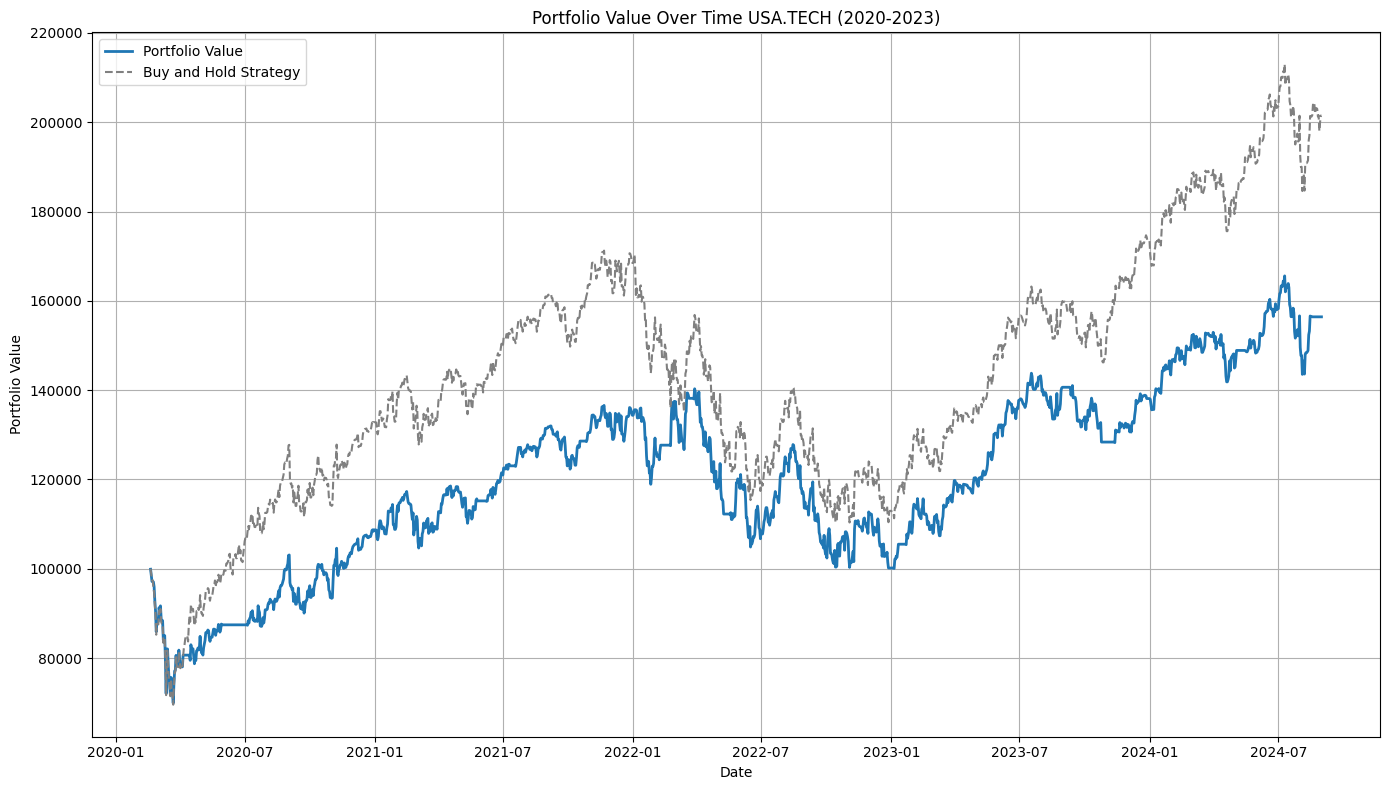

In [12]:
initial_price = filtered_data["Close"].iloc[0]
initial_capital = 100000
buy_hold_portfolio_value = filtered_data["Close"] / initial_price * initial_capital
# Plot portfolio value over time
plt.figure(figsize=(14, 8))
plt.plot(
    backtested_data["Date"],
    backtested_data["Portfolio_Value"],
    label="Portfolio Value",
    linewidth=2,
)

# Plot buy and hold strategy
plt.plot(
    filtered_data["Date"],
    buy_hold_portfolio_value,
    label="Buy and Hold Strategy",
    linestyle="--",
    color="gray",
)

# Add title and labels
plt.title("Portfolio Value Over Time USA.TECH (2020-2023)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [84]:
backtest_results

{'Final Portfolio Value': 156419.26541339888,
 'Cumulative Return (%)': 56.419265413398875,
 'Sharpe Ratio': np.float64(0.43335813212272795),
 'Maximum Drawdown (%)': np.float64(-30.030966111237046),
 'Total Number of Trades': np.int64(599),
 'Winning Trades': np.float64(-1.2350939679915578),
 'Losing Trades': np.float64(0.0886848145945105)}

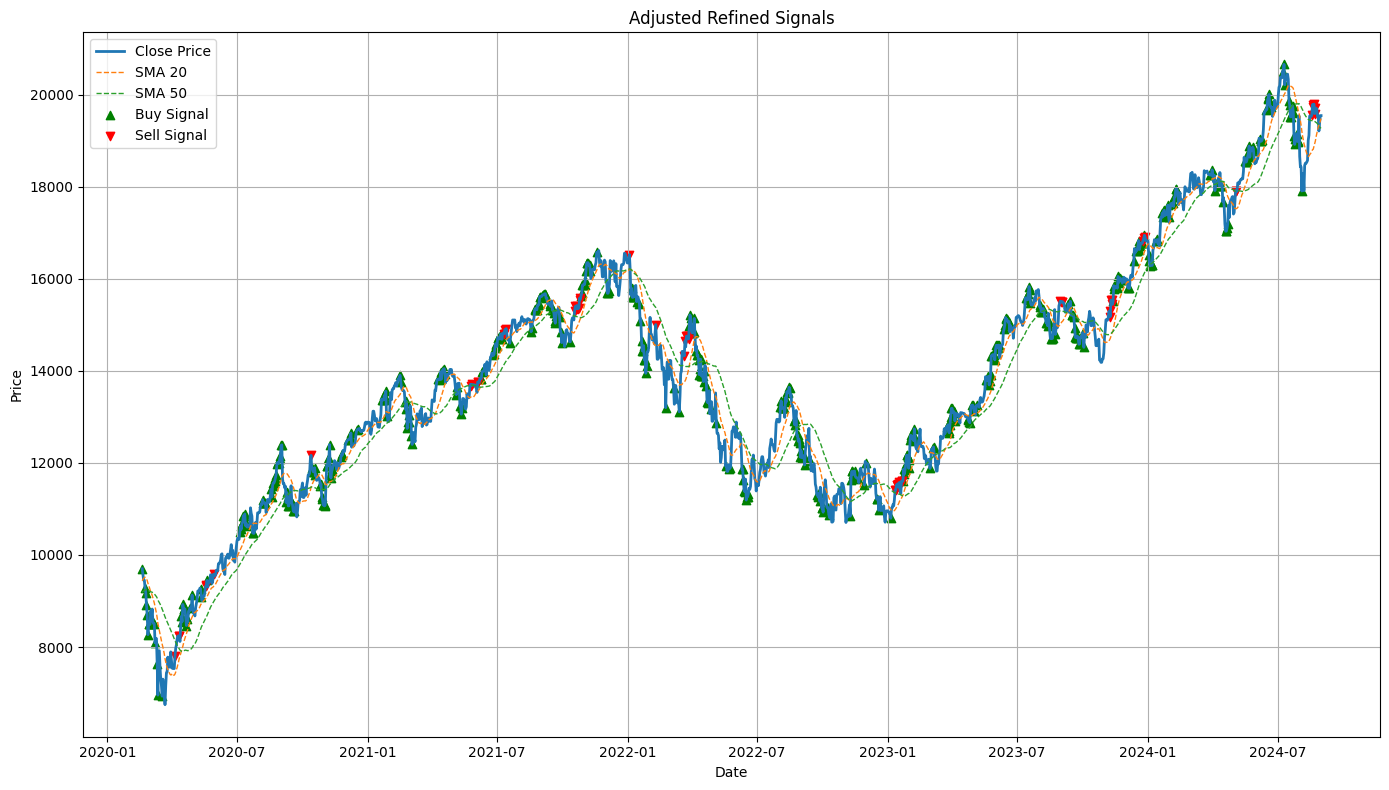

In [86]:
# plot signals
plt.figure(figsize=(14, 8))
plt.plot(
    filtered_data["Date"], filtered_data["Close"], label="Close Price", linewidth=2
)
plt.plot(
    filtered_data["Date"],
    filtered_data["SMA_20"],
    label="SMA 20",
    linestyle="--",
    linewidth=1,
)
plt.plot(
    filtered_data["Date"],
    filtered_data["SMA_50"],
    label="SMA 50",
    linestyle="--",
    linewidth=1,
)
plt.scatter(
    filtered_data[filtered_data["Adjusted_Signal"] == 1]["Date"],
    filtered_data[filtered_data["Adjusted_Signal"] == 1]["Close"],
    marker="^",
    color="g",
    label="Buy Signal",
)
plt.scatter(
    filtered_data[filtered_data["Adjusted_Signal"] == -1]["Date"],
    filtered_data[filtered_data["Adjusted_Signal"] == -1]["Close"],
    marker="v",
    color="r",
    label="Sell Signal",
)
plt.title("Adjusted Refined Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
import numpy as np
from tqdm import tqdm


# Walk-forward optimization function
def optimize_signal_thresholds(data, param_grid, initial_capital=100000):
    """
    Optimize thresholds for `adjust_signals` to maximize returns and Sharpe ratio.

    Parameters:
        data (pd.DataFrame): DataFrame with required columns for `adjust_signals`.
        param_grid (dict): Dictionary of parameter ranges for optimization.
        initial_capital (int): Starting capital for backtesting.

    Returns:
        dict: Best parameters for thresholds.
        float: Best Sharpe ratio achieved during optimization.
    """
    # Initialize walk-forward cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    best_params = None
    best_performance = -np.inf

    # Iterate over parameter combinations
    for params in tqdm(ParameterGrid(param_grid)):
        total_return = []
        sharpe_ratios = []

        for train_index, test_index in tscv.split(data):
            # Train/Test split
            train_data = data.iloc[train_index].copy()
            test_data = data.iloc[test_index].copy()

            # Apply the `adjust_signals` function with current parameters
            train_data = adjust_signals(
                train_data,
                rsi_oversold=params["rsi_oversold"],
                rsi_overbought=params["rsi_overbought"],
                bb_band=params["bb_band"],
                adx_threshold=params["adx_threshold"],
                buy_threshold=params["buy_threshold"],
                sell_threshold=params["sell_threshold"],
            )
            test_data = adjust_signals(
                test_data,
                rsi_oversold=params["rsi_oversold"],
                rsi_overbought=params["rsi_overbought"],
                bb_band=params["bb_band"],
                adx_threshold=params["adx_threshold"],
                buy_threshold=params["buy_threshold"],
                sell_threshold=params["sell_threshold"],
            )

            # Backtesting
            _, backtest_results = backtest_with_atr_stoploss(
                test_data,
                initial_capital=initial_capital,
                atr_multiplier=params["atr_multiplier"],
            )

            # Calculate performance metrics
            total_return.append(backtest_results["Cumulative Return (%)"])
            sharpe_ratios.append(backtest_results["Sharpe Ratio"])

        # Average performance across splits
        avg_return = np.mean(total_return)
        avg_sharpe = np.mean(sharpe_ratios)

        # Update best parameters
        if avg_sharpe > best_performance:
            best_performance = avg_sharpe
            best_params = params

    return best_params, best_performance


In [88]:
# Parameter grid
param_grid = {
    "rsi_oversold": [20, 25, 30, 35, 40, 45],
    "rsi_overbought": [60, 65, 70, 75],
    "bb_band": [0.2, 0.3, 0.5, 0.7],
    "adx_threshold": [20, 25, 30],
    "buy_threshold": [2, 3, 4],
    "sell_threshold": [2, 3, 4],
    "atr_multiplier": [1, 2, 3],
}

# Run optimization
best_params, best_sharpe = optimize_signal_thresholds(snp500_data, param_grid)

print("Best Parameters:", best_params)
print("Best Sharpe Ratio:", best_sharpe)


100%|██████████| 7776/7776 [05:53<00:00, 21.98it/s]

Best Parameters: {'adx_threshold': 30, 'atr_multiplier': 3, 'bb_band': 0.3, 'buy_threshold': 2, 'rsi_overbought': 65, 'rsi_oversold': 20, 'sell_threshold': 4}
Best Sharpe Ratio: 0.9541362336716


In [ ]:
best_params = {
    "adx_threshold": 30,
    "atr_multiplier": 3,
    "bb_band": 0.3,
    "buy_threshold": 2,
    "rsi_overbought": 65,
    "rsi_oversold": 20,
    "sell_threshold": 4,
}


In [16]:
# Apply the best parameters to the data

valid_data = snp500_data.copy()

valid_data = valid_data.loc[valid_data["Date"] >= "2021-01-01"]

snp500_data_optimized = adjust_signals(
    valid_data,
    rsi_oversold=best_params["rsi_oversold"],
    rsi_overbought=best_params["rsi_overbought"],
    bb_band=best_params["bb_band"],
    adx_threshold=best_params["adx_threshold"],
    buy_threshold=best_params["buy_threshold"],
    sell_threshold=best_params["sell_threshold"],
)

In [17]:
backtested_data, backtest_results = backtest_with_atr_stoploss(
    snp500_data_optimized, atr_multiplier=best_params["atr_multiplier"]
)

In [18]:
backtest_results

{'Final Portfolio Value': 184639.05687565156,
 'Cumulative Return (%)': 84.63905687565155,
 'Sharpe Ratio': np.float64(0.7146038305961601),
 'Maximum Drawdown (%)': np.float64(-27.0136056990533),
 'Total Number of Trades': np.int64(906),
 'Winning Trades': np.float64(-0.3081992794144719),
 'Losing Trades': np.float64(0.10789367687509943)}

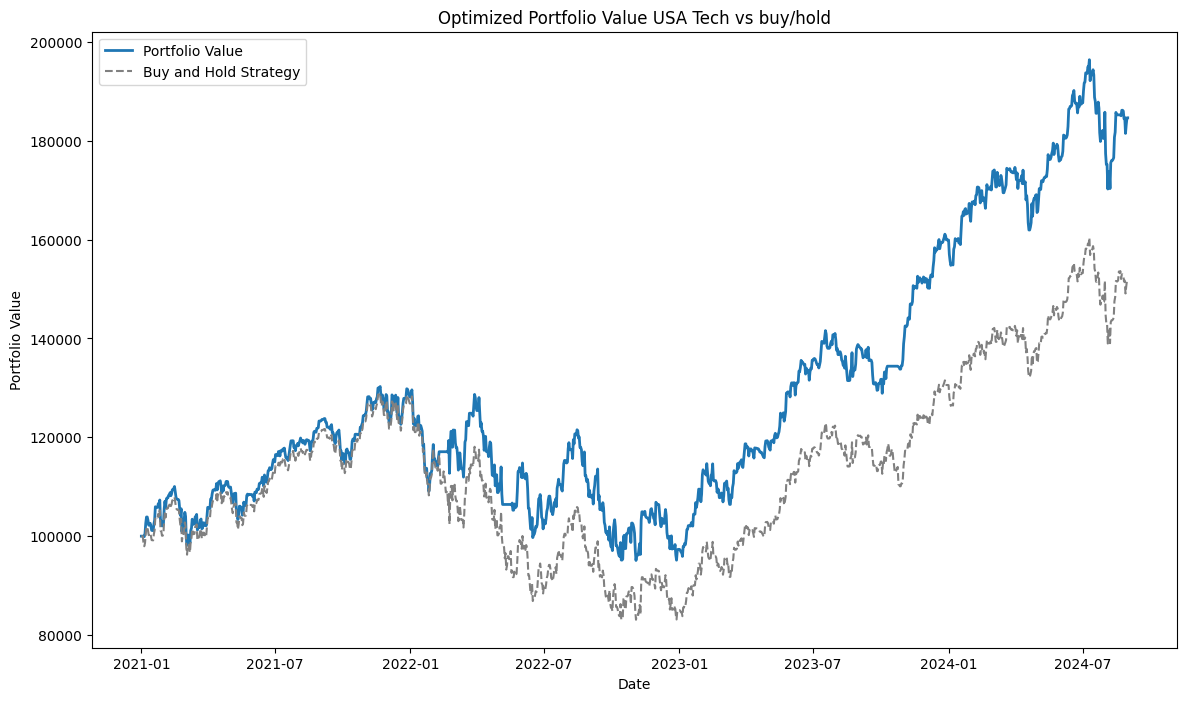

In [20]:
# plot equity curve
plt.figure(figsize=(14, 8))
plt.plot(
    backtested_data["Date"],
    backtested_data["Portfolio_Value"],
    label="Portfolio Value",
    linewidth=2,
)

# plot buy and hold strategy
initial_price = valid_data["Close"].iloc[0]
initial_capital = 100000
buy_hold_portfolio_value = valid_data["Close"] / initial_price * initial_capital

plt.plot(
    valid_data["Date"],
    buy_hold_portfolio_value,
    label="Buy and Hold Strategy",
    linestyle="--",
    color="gray",
)

# heading
plt.title("Optimized Portfolio Value USA Tech vs buy/hold")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()


In [22]:
# Redefine the target variable based on changes in close prices
def prepare_ml_data_with_price_change(
    data, threshold=0.002
):  # 0.2% threshold for Buy/Sell
    # Calculate the percentage change in close prices
    data["Close_Change"] = data["Close"].pct_change().shift(-1)

    # Define target variable
    data["Target"] = 0  # Default Hold
    data.loc[data["Close_Change"] > threshold, "Target"] = 1  # Buy
    data.loc[data["Close_Change"] < -threshold, "Target"] = -1  # Sell

    data.drop(columns=["Close_Change"], inplace=True)

    # Feature Engineering: Avoid using future information
    data["Momentum"] = data["Close"].pct_change(5)  # 5-day momentum
    data["ATR_Lag_1"] = data["ATR"].shift(1)
    data["RSI_Lag_1"] = data["RSI"].shift(1)
    data["SMA_20_Lag_1"] = data["SMA_20"].shift(1)
    data["SMA_50_Lag_1"] = data["SMA_50"].shift(1)
    data["Daily_Return_Lag_1"] = data["Daily_Return"].shift(1)
    data["BB_Width_Lag_1"] = (data["BB_Upper"] - data["BB_Lower"]).shift(1)

    # Drop rows with NaNs (caused by lags and shifts)
    return data.dropna()


# Apply the new data preparation method
snp500_ml_data = prepare_ml_data_with_price_change(snp500_data_optimized)

# Define features (X) and target (y)
features = [
    "RSI_Lag_1",
    "SMA_20_Lag_1",
    "SMA_50_Lag_1",
    "Daily_Return_Lag_1",
    "BB_Width_Lag_1",
    "Momentum",
    "ADX",
    "ATR_Lag_1",
]
X = snp500_ml_data[features]
y = snp500_ml_data["Target"]

# Check the updated dataset structure
snp500_ml_data[["Date", "Target"] + features].head()


,Date,Target,RSI_Lag_1,SMA_20_Lag_1,SMA_50_Lag_1,Daily_Return_Lag_1,BB_Width_Lag_1,Momentum,ADX,ATR_Lag_1
371,2021-01-06,1,43.381564,12766.8765,12485.47576,-0.000999,351.875060,-0.013567,15.559953,107.951429
372,2021-01-07,1,52.696657,12766.2670,12500.16736,0.007020,353.370436,0.006395,15.140792,121.828571
373,2021-01-08,0,64.939670,12777.6790,12522.32696,0.020236,394.586296,0.019175,14.676248,139.521429
374,2021-01-09,-1,70.302611,12796.9335,12544.69940,0.012097,498.628978,0.034637,14.211705,153.100714
375,2021-01-10,-1,70.302611,12815.7010,12569.42420,0.000000,574.694140,0.032938,13.873070,153.100714


In [40]:
# Walk-forward validation with ensemble model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)

# Initialize walk-forward cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Ensemble model: Combine Random Forest and Gradient Boosting
ensemble_model = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(random_state=42, class_weight="balanced")),
        ("gb", GradientBoostingClassifier(random_state=42)),
    ],
    voting="soft",  # Use soft voting for confidence scores
)

# Store results
results_df = pd.DataFrame(
    columns=["Date", "ML_Prediction", "Confidence", "TA_Signal", "Hybrid_Signal"]
)
feature_importance_df = pd.DataFrame(columns=["features", "importance"])

for train_index, test_index in tscv.split(X):
    # Split data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dates_test = snp500_ml_data.iloc[test_index]["Date"]
    ta_signals_test = snp500_ml_data.iloc[test_index]["Adjusted_Signal"]

    # Train the ensemble model
    ensemble_model.fit(X_train, y_train)

    # print feature importance and store the results
    feature_importance_df = pd.concat(
        [
            feature_importance_df,
            pd.DataFrame(
                {
                    "features": features,
                    "importance": ensemble_model.estimators_[0].feature_importances_,
                }
            ),
        ],
        ignore_index=True,
    )

    print(feature_importance_df.head())

    # Predict on the test set
    probabilities = ensemble_model.predict_proba(X_test)
    predictions = ensemble_model.predict(X_test)
    confidences = probabilities.max(axis=1)  # Confidence scores (max probability)

    # Generate Hybrid Signal: Use ML prediction if confidence is high, otherwise TA signal
    high_confidence_threshold = 0.8
    hybrid_signals = [
        pred if conf > high_confidence_threshold else ta
        for pred, conf, ta in zip(predictions, confidences, ta_signals_test)
    ]

    # Store results
    temp_df = pd.DataFrame(
        {
            "Date": dates_test,
            "Close": snp500_ml_data.iloc[test_index]["Close"],
            "ATR": snp500_ml_data.iloc[test_index]["ATR"],
            "ML_Prediction": predictions,
            "Confidence": confidences,
            "TA_Signal": ta_signals_test,
            "Hybrid_Signal": hybrid_signals,
        }
    )
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Sort by date
results_df.sort_values(by="Date", inplace=True)
results_df.reset_index(drop=True, inplace=True)

# Check the results
print(results_df.head())


/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_30064/3479407380.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat(
/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_30064/3479407380.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


             features  importance
0           RSI_Lag_1    0.126129
1        SMA_20_Lag_1    0.114750
2        SMA_50_Lag_1    0.112738
3  Daily_Return_Lag_1    0.129994
4      BB_Width_Lag_1    0.117025
             features  importance
0           RSI_Lag_1    0.126129
1        SMA_20_Lag_1    0.114750
2        SMA_50_Lag_1    0.112738
3  Daily_Return_Lag_1    0.129994
4      BB_Width_Lag_1    0.117025
             features  importance
0           RSI_Lag_1    0.126129
1        SMA_20_Lag_1    0.114750
2        SMA_50_Lag_1    0.112738
3  Daily_Return_Lag_1    0.129994
4      BB_Width_Lag_1    0.117025
             features  importance
0           RSI_Lag_1    0.126129
1        SMA_20_Lag_1    0.114750
2        SMA_50_Lag_1    0.112738
3  Daily_Return_Lag_1    0.129994
4      BB_Width_Lag_1    0.117025
             features  importance
0           RSI_Lag_1    0.126129
1        SMA_20_Lag_1    0.114750
2        SMA_50_Lag_1    0.112738
3  Daily_Return_Lag_1    0.129994
4      BB_Widt

In [41]:
results_df.sort_values(by="Confidence", ascending=False)

,Date,ML_Prediction,Confidence,TA_Signal,Hybrid_Signal,Close,ATR
639,2023-05-19,0,0.837877,1,0,13790.089,124.772857
695,2023-07-14,0,0.826480,1,0,15572.019,127.640571
147,2022-01-12,-1,0.804236,1,-1,15855.829,257.817143
94,2021-11-20,-1,0.774172,1,1,16576.819,147.960429
200,2022-03-06,1,0.767103,1,1,13618.009,460.750071
...,...,...,...,...,...,...,...
655,2023-06-04,-1,0.344475,1,1,14497.299,170.100286
852,2023-12-18,1,0.342045,1,1,16718.879,170.692857
594,2023-04-04,0,0.340880,1,1,13103.299,173.514286
810,2023-11-06,1,0.339100,0,0,15130.019,198.037429


In [42]:
# Updated Backtesting Logic with Transaction Costs, Slippage, and ATR-based Stop Loss
def backtest_with_atr_stoploss(
    data,
    initial_capital=100000,
    transaction_cost=0.001,
    slippage=0.001,
    atr_multiplier=2,
):
    """
    Perform backtesting with transaction costs, slippage, and ATR-based stop loss.

    Parameters:
        data (pd.DataFrame): DataFrame with columns ['Close', 'ATR', 'Adjusted_Signal'].
        initial_capital (float): Starting capital for the backtest.
        transaction_cost (float): Proportional transaction cost per trade.
        slippage (float): Proportional slippage on each trade.
        atr_multiplier (float): Multiplier for ATR-based stop loss.

    Returns:
        pd.DataFrame: Updated DataFrame with portfolio values and metrics.
        dict: Backtest performance metrics.
    """
    position = 0  # Number of shares held
    cash = initial_capital  # Starting cash
    portfolio_value = []  # Track portfolio value over time
    entry_price = 0  # Track entry price for stop loss calculation

    for _, row in data.iterrows():
        # Adjusted prices for slippage
        buy_price = row["Close"] * (1 + slippage)
        sell_price = row["Close"] * (1 - slippage)

        # Check for stop loss condition
        if position > 0 and row["Close"] < entry_price - (row["ATR"] * atr_multiplier):
            cash = position * sell_price * (1 - transaction_cost)  # Sell all shares
            position = 0  # Reset position
            entry_price = 0  # Reset entry price

        # Execute signals
        if row["Hybrid_Signal"] == 1 and cash > 0:  # Buy signal
            position = cash / buy_price  # Buy as many shares as possible
            cash = 0  # Use all cash
            entry_price = buy_price  # Set entry price

        elif row["Hybrid_Signal"] == -1 and position > 0:  # Sell signal
            cash = position * sell_price * (1 - transaction_cost)  # Sell all shares
            position = 0  # Reset position
            entry_price = 0  # Reset entry price

        # Calculate portfolio value
        current_value = cash + (
            position * row["Close"]
        )  # Cash + value of held position
        portfolio_value.append(current_value)

    # Add portfolio value to the dataframe
    data["Portfolio_Value"] = portfolio_value

    # Calculate performance metrics
    final_portfolio_value = portfolio_value[-1]
    cumulative_return = (
        (final_portfolio_value - initial_capital) / initial_capital * 100
    )
    data["Daily_Return"] = data["Portfolio_Value"].pct_change()
    sharpe_ratio = (
        data["Daily_Return"].mean() / data["Daily_Return"].std() * (252**0.5)
        if data["Daily_Return"].std() != 0
        else 0
    )
    max_drawdown = (
        data["Portfolio_Value"] / data["Portfolio_Value"].cummax() - 1
    ).min()

    num_trades = data["Hybrid_Signal"].abs().sum()
    win_trades = data["Daily_Return"][data["Hybrid_Signal"] == 1].sum()
    loss_trades = data["Daily_Return"][data["Hybrid_Signal"] == -1].sum()

    # Results summary
    backtest_results = {
        "Final Portfolio Value": final_portfolio_value,
        "Cumulative Return (%)": cumulative_return,
        "Sharpe Ratio": sharpe_ratio,
        "Maximum Drawdown (%)": max_drawdown * 100,
        "Total Number of Trades": num_trades,
        "Winning Trades": win_trades,
        "Losing Trades": loss_trades,
    }

    return data, backtest_results


In [51]:
backtested_data, backtest_results = backtest_with_atr_stoploss(
    results_df, atr_multiplier=3
)

In [52]:
backtest_results

{'Final Portfolio Value': 160390.8190194137,
 'Cumulative Return (%)': 60.3908190194137,
 'Sharpe Ratio': np.float64(0.6596123206939508),
 'Maximum Drawdown (%)': np.float64(-26.107456457369416),
 'Total Number of Trades': 768,
 'Winning Trades': np.float64(-0.2314915751312634),
 'Losing Trades': np.float64(0.10309568050943485)}

In [27]:
results_df["Date"]

0      2021-08-18
1      2021-08-19
2      2021-08-20
3      2021-08-21
4      2021-08-22
          ...    
1105   2024-08-27
1106   2024-08-28
1107   2024-08-29
1108   2024-08-30
1109   2024-08-31
Name: Date, Length: 1110, dtype: datetime64[ns]

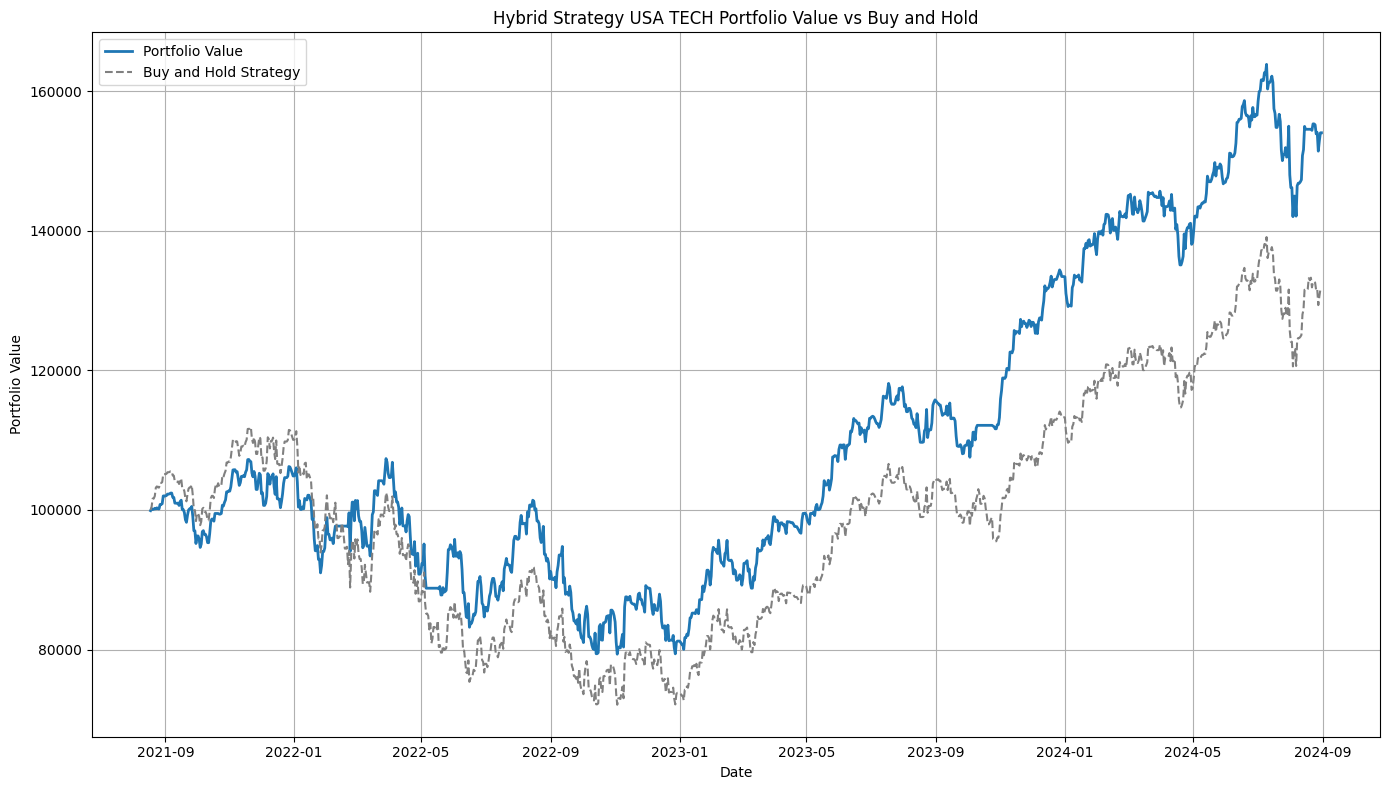

In [28]:
# plot results df vs buy and hold strategy

# Calculate buy and hold strategy
results_df["Close"] = snp500_ml_data.loc[
    snp500_ml_data["Date"].isin(results_df["Date"]), "Close"
].values
initial_price = results_df["Close"].iloc[0]
buy_hold_portfolio_value = results_df["Close"] / initial_price

# Plot portfolio value over time
plt.figure(figsize=(14, 8))
plt.plot(
    results_df["Date"],
    results_df["Portfolio_Value"],
    label="Portfolio Value",
    linewidth=2,
)
plt.plot(
    results_df["Date"],
    buy_hold_portfolio_value * initial_capital,
    label="Buy and Hold Strategy",
    linestyle="--",
    color="gray",
)
plt.title("Hybrid Strategy USA TECH Portfolio Value vs Buy and Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Monte Carlo

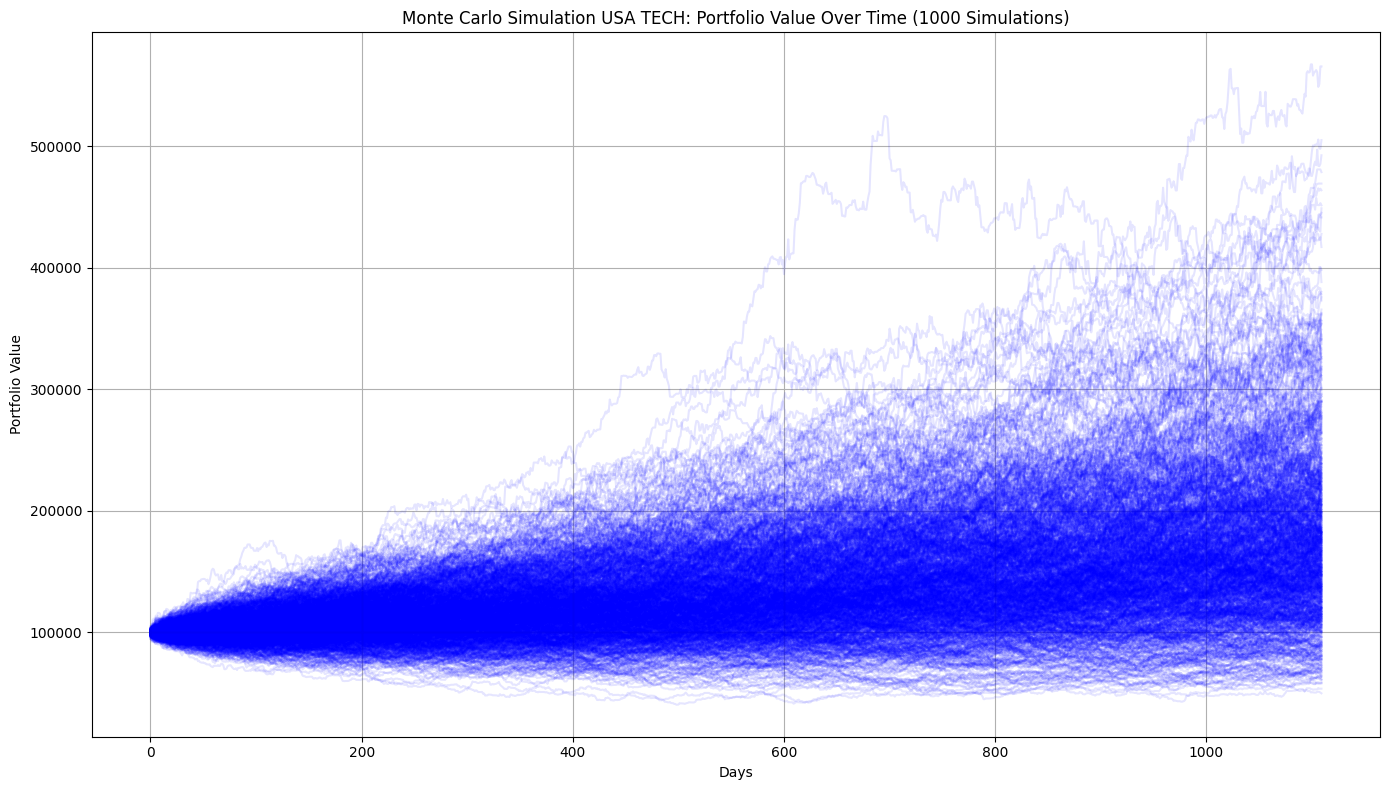

Mean Daily Return: 0.000514
Standard Deviation of Daily Returns: 0.012009
Corrected Sharpe Ratio: 0.57


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def monte_carlo_simulation(
    portfolio_values, num_simulations=1000, num_days=None, initial_capital=100000
):
    """
    Perform Monte Carlo simulation for the portfolio value.

    Parameters:
        portfolio_values (list): List of historical portfolio values for the backtest.
        num_simulations (int): Number of simulations to run.
        num_days (int): Number of days to simulate. If None, use the length of portfolio values.
        initial_capital (float): The starting capital for the simulation.

    Returns:
        np.ndarray: Simulated portfolio values for each run.
    """
    # Use the number of days in portfolio if not provided
    if num_days is None:
        num_days = len(portfolio_values)

    # Calculate daily returns
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]

    # Simulate multiple paths
    simulated_portfolios = np.zeros((num_simulations, num_days))
    for i in range(num_simulations):
        simulated_returns = np.random.choice(daily_returns, size=num_days, replace=True)
        simulated_portfolios[i] = initial_capital * (1 + simulated_returns).cumprod()

    return simulated_portfolios


# Historical portfolio values from backtesting
historical_portfolio_values = results_df["Portfolio_Value"].values

# Run the Monte Carlo simulation
simulated_portfolios = monte_carlo_simulation(
    historical_portfolio_values, num_simulations=1000
)

# Plot the simulated portfolio paths
plt.figure(figsize=(14, 8))
plt.plot(simulated_portfolios.T, color="blue", alpha=0.1)
plt.title(
    "Monte Carlo Simulation USA TECH: Portfolio Value Over Time (1000 Simulations)"
)
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.grid()
plt.tight_layout()
plt.show()

# Analyze the results

daily_returns_simulated = (
    simulated_portfolios[:, 1:] - simulated_portfolios[:, :-1]
) / simulated_portfolios[:, :-1]
mean_daily_return = np.mean(daily_returns_simulated)
std_daily_return = np.std(daily_returns_simulated)

# Sharpe ratio using daily returns
risk_free_rate = 0.02 / 252  # Assuming 2% annual risk-free rate
excess_daily_return = mean_daily_return - risk_free_rate
sharpe_ratio = (
    excess_daily_return / std_daily_return * np.sqrt(252)
)  # Annualized Sharpe Ratio

# Print corrected key metrics
print(f"Mean Daily Return: {mean_daily_return:.6f}")
print(f"Standard Deviation of Daily Returns: {std_daily_return:.6f}")
print(f"Corrected Sharpe Ratio: {sharpe_ratio:.2f}")


# Sensitivity analysis

In [ ]:
import pandas as pd
import numpy as np


def sensitivity_analysis(data, param_grid, initial_capital=100000):
    """
    Perform sensitivity analysis by varying parameters and tracking performance.

    Parameters:
        data (pd.DataFrame): Historical data for the strategy.
        param_grid (dict): Dictionary of parameter ranges for testing.
        initial_capital (int): Starting portfolio capital.

    Returns:
        pd.DataFrame: Sensitivity analysis results.
    """
    results = []

    # Iterate over all parameter combinations
    for params in ParameterGrid(param_grid):
        # Apply signals with the current parameter set
        data_copy = data.copy()
        data_copy = adjust_signals(
            data_copy,
            rsi_oversold=params["rsi_oversold"],
            rsi_overbought=params["rsi_overbought"],
            bb_band=params["bb_band"],
            adx_threshold=params["adx_threshold"],
            buy_threshold=params["buy_threshold"],
            sell_threshold=params["sell_threshold"],
        )

        # Backtest the strategy
        position = 0
        cash = initial_capital
        portfolio_value = []
        for _, row in data_copy.iterrows():
            current_price = row["Close"]
            if row["Adjusted_Signal"] == 1:  # Buy signal
                if cash > 0:
                    position = cash / current_price
                    cash = 0
            elif row["Adjusted_Signal"] == -1:  # Sell signal
                if position > 0:
                    cash = position * current_price
                    position = 0
            portfolio_value.append(cash + position * current_price)

        # Calculate performance metrics
        cumulative_return = (portfolio_value[-1] - initial_capital) / initial_capital
        daily_returns = np.diff(portfolio_value) / portfolio_value[:-1]
        sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)

        # Store the results
        results.append(
            {
                **params,
                "Cumulative Return": cumulative_return,
                "Sharpe Ratio": sharpe_ratio,
            }
        )

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


# Define the parameter grid
param_grid = {
    "rsi_oversold": [30, 35, 40],
    "rsi_overbought": [60, 65, 70],
    "bb_band": [0.3, 0.5, 0.7],
    "adx_threshold": [20, 25, 30],
    "atr_multiplier": [1.0, 1.5, 2.0],
    "buy_threshold": [2, 3],
    "sell_threshold": [2, 3],
}

# Run sensitivity analysis
sensitivity_results = sensitivity_analysis(snp500_data, param_grid)


In [160]:
sensitivity_results.iloc[0]

adx_threshold        20.000000
atr_multiplier        1.000000
bb_band               0.300000
buy_threshold         2.000000
rsi_overbought       60.000000
rsi_oversold         30.000000
sell_threshold        2.000000
Cumulative Return     0.187039
Sharpe Ratio          0.764746
Name: 0, dtype: float64

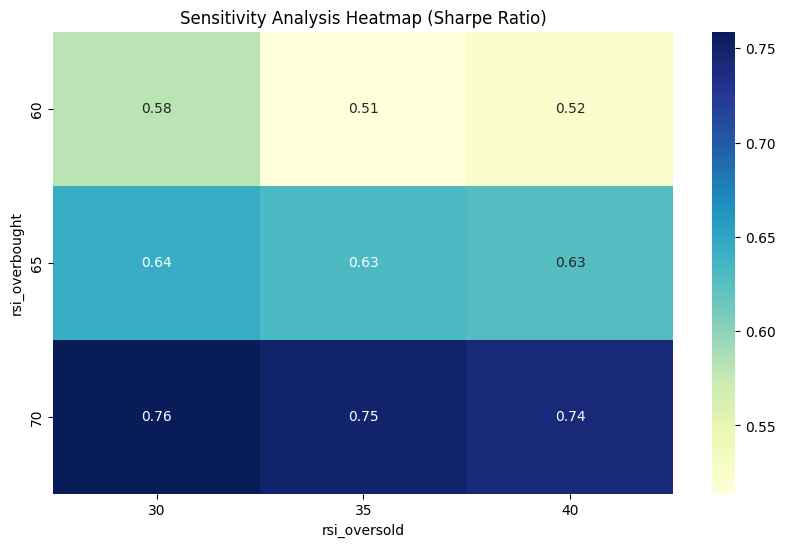

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_heatmap(sensitivity_results, x_param, y_param, metric):
    """
    Plot a heatmap for sensitivity results.

    Parameters:
        sensitivity_results (pd.DataFrame): Results of sensitivity analysis.
        x_param (str): Parameter for the x-axis.
        y_param (str): Parameter for the y-axis.
        metric (str): Metric to visualize (e.g., 'Sharpe Ratio').
    """
    # Pivot data for heatmap
    heatmap_data = sensitivity_results.pivot_table(
        values=metric, index=y_param, columns=x_param, aggfunc="mean"
    )

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(f"Sensitivity Analysis Heatmap ({metric})")
    plt.xlabel(x_param)
    plt.ylabel(y_param)
    plt.show()


# Example: Plot heatmap for Sharpe Ratio
plot_heatmap(
    sensitivity_results,
    x_param="rsi_oversold",
    y_param="rsi_overbought",
    metric="Sharpe Ratio",
)

# plot_heatmap(sensitivity_results, x_param='adx_threshold', y_param='rsi_overbought', metric='Cumulative Return')


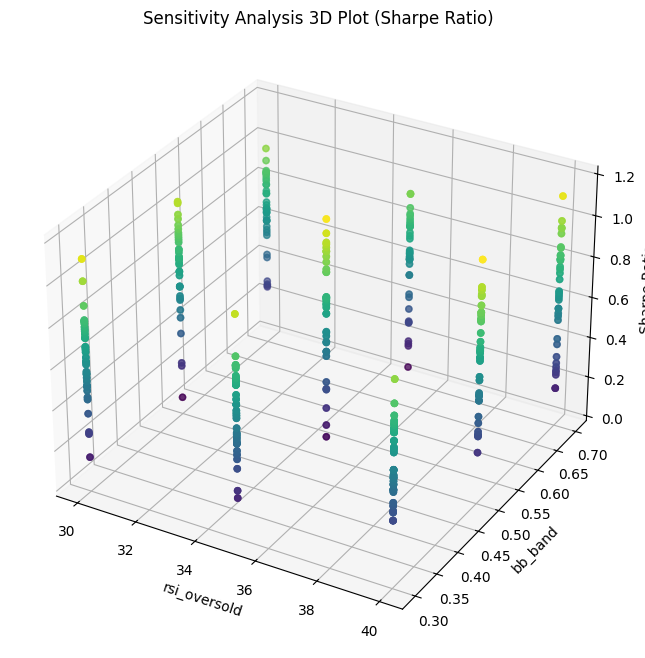

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_surface(sensitivity_results, x_param, y_param, metric):
    """
    Plot a 3D surface plot for sensitivity results.

    Parameters:
        sensitivity_results (pd.DataFrame): Results of sensitivity analysis.
        x_param (str): Parameter for the x-axis.
        y_param (str): Parameter for the y-axis.
        metric (str): Metric for the z-axis (e.g., 'Sharpe Ratio').
    """
    # Extract relevant data
    x = sensitivity_results[x_param]
    y = sensitivity_results[y_param]
    z = sensitivity_results[metric]

    # Plot 3D surface
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x, y, z, c=z, cmap="viridis", marker="o")

    ax.set_title(f"Sensitivity Analysis 3D Plot ({metric})")
    ax.set_xlabel(x_param)
    ax.set_ylabel(y_param)
    ax.set_zlabel(metric)
    plt.show()


# Example: Plot 3D surface for Sharpe Ratio
plot_3d_surface(
    sensitivity_results,
    x_param="rsi_oversold",
    y_param="bb_band",
    metric="Sharpe Ratio",
)


/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_31672/4020555768.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=param, y=metric, data=grouped_data, palette='Blues_d')


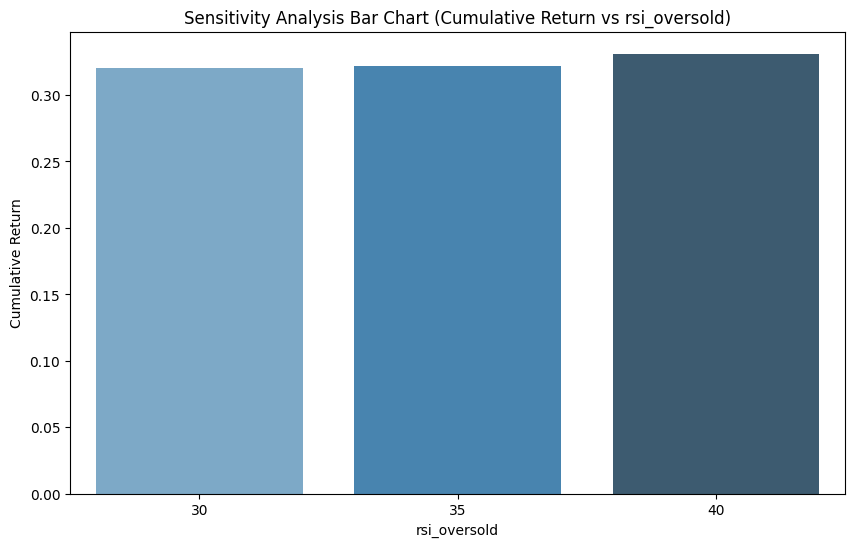

/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_31672/4020555768.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=param, y=metric, data=grouped_data, palette='Blues_d')


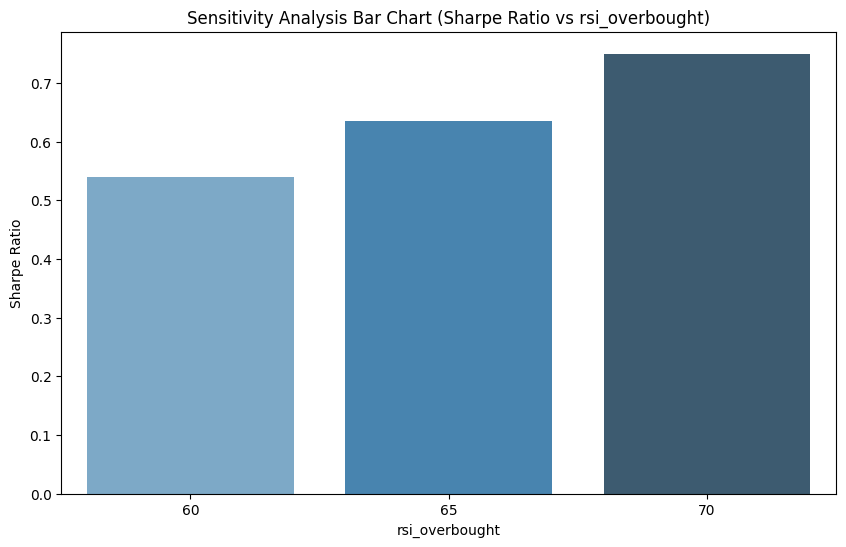

/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_31672/4020555768.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=param, y=metric, data=grouped_data, palette='Blues_d')


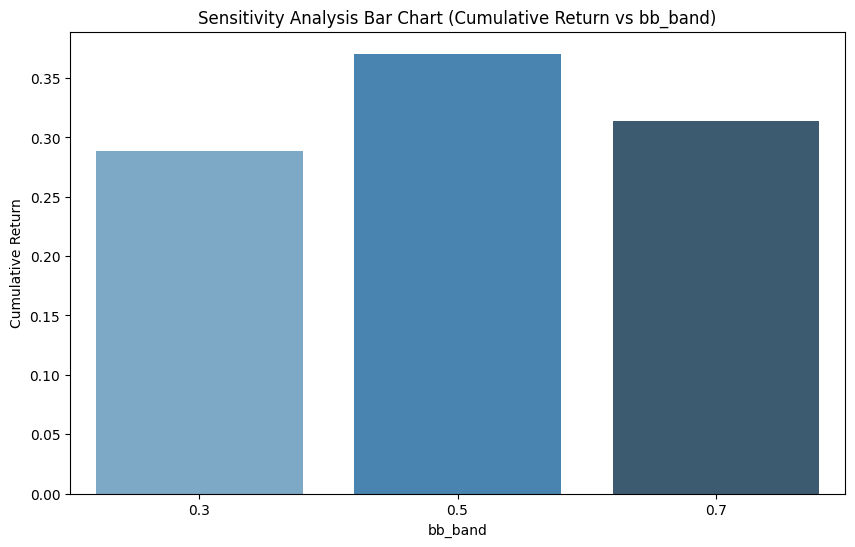

/var/folders/ts/x9s4jq3d03v5_s2wlg8bkg8r0000gn/T/ipykernel_31672/4020555768.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=param, y=metric, data=grouped_data, palette='Blues_d')


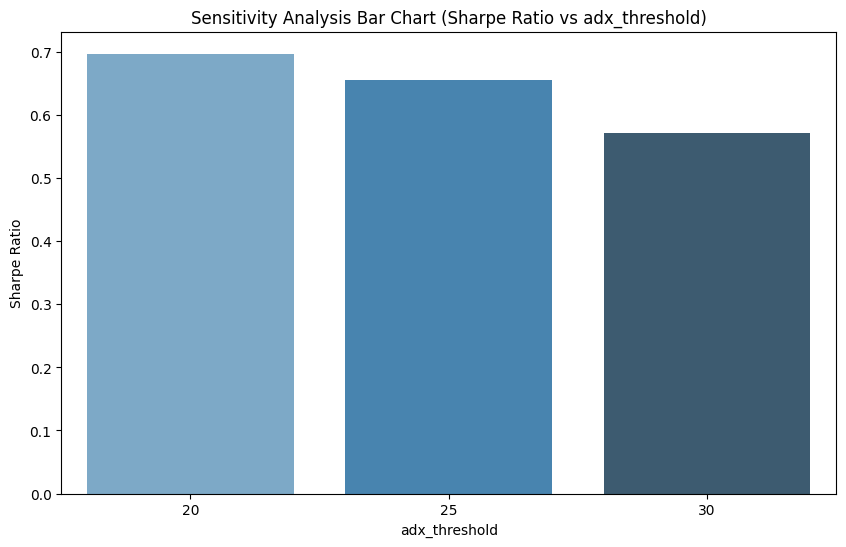

In [ ]:
def plot_bar_chart(sensitivity_results, param, metric):
    """
    Plot a bar chart for a single parameter and metric.

    Parameters:
        sensitivity_results (pd.DataFrame): Results of sensitivity analysis.
        param (str): Parameter to visualize.
        metric (str): Metric to evaluate (e.g., 'Cumulative Return').
    """
    # Group by parameter and calculate the mean metric
    grouped_data = sensitivity_results.groupby(param)[metric].mean().reset_index()

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=param, y=metric, data=grouped_data, palette="Blues_d")
    plt.title(f"Sensitivity Analysis Bar Chart ({metric} vs {param})")
    plt.xlabel(param)
    plt.ylabel(metric)
    plt.show()


# Example: Plot bar chart for RSI Oversold and Cumulative Return
plot_bar_chart(sensitivity_results, param="rsi_oversold", metric="Cumulative Return")
plot_bar_chart(sensitivity_results, param="rsi_overbought", metric="Sharpe Ratio")
plot_bar_chart(sensitivity_results, param="bb_band", metric="Cumulative Return")
plot_bar_chart(sensitivity_results, param="adx_threshold", metric="Sharpe Ratio")


## EDA

In [166]:
import matplotlib.pyplot as plt
import talib as ta


def plot_indicators(data):
    data["rsi"] = ta.RSI(data["Close"], timeperiod=14)
    data["macd"], data["macd_signal"], _ = ta.MACD(data["Close"])
    data["sma_short"] = ta.SMA(data["Close"], timeperiod=7)
    data["sma_long"] = ta.SMA(data["Close"], timeperiod=14)
    data["atr"] = ta.ATR(data["High"], data["Low"], data["Close"], timeperiod=14)
    data["adx"] = ta.ADX(data["High"], data["Low"], data["Close"], timeperiod=14)
    data["trend_strength"] = abs(data["macd"] - data["macd_signal"])
    data["momentum"] = data["Close"].pct_change(periods=10)  # Momentum calculation

    data["stochastic_k"], _ = talib.STOCH(
        data["High"],
        data["Low"],
        data["Close"],
        fastk_period=14,
        slowk_period=3,
        slowk_matype=0,
        slowd_period=3,
        slowd_matype=0,
    )

    # Adaptive thresholds
    data["trend_strength_threshold"] = (
        data["trend_strength"].rolling(50).mean().fillna(data["trend_strength"].mean())
    )
    data["momentum_threshold"] = (
        data["momentum"].rolling(50).mean().fillna(data["momentum"].mean())
    )

    # Plot price and SMA
    plt.figure(figsize=(12, 6))
    plt.plot(data["Close"], label="Close Price")
    plt.plot(data["sma_short"], label="SMA 50")
    plt.plot(data["sma_long"], label="SMA 200")
    plt.title("Price and SMA")
    plt.legend()
    plt.show()

    # Plot RSI
    plt.figure(figsize=(12, 4))
    plt.plot(data["rsi"], label="RSI")
    plt.axhline(30, color="red", linestyle="--", label="Oversold")
    plt.axhline(70, color="green", linestyle="--", label="Overbought")
    plt.title("RSI")
    plt.legend()
    plt.show()

    # Plot MACD
    plt.figure(figsize=(12, 4))
    plt.plot(data["macd"], label="MACD")
    plt.plot(data["macd_signal"], label="MACD Signal")
    plt.axhline(0, color="black", linestyle="--")
    plt.title("MACD")
    plt.legend()
    plt.show()

    # Plot ATR
    plt.figure(figsize=(12, 4))
    plt.plot(data["atr"], label="ATR")
    plt.title("ATR")
    plt.legend()
    plt.show()

    # Plot ADX
    plt.figure(figsize=(12, 4))
    plt.plot(data["adx"], label="ADX")
    plt.axhline(20, color="red", linestyle="--", label="Weak Trend")
    plt.title("ADX")
    plt.legend()
    plt.show()

    # Plot trend strength with threshold
    plt.figure(figsize=(12, 4))
    plt.plot(data["trend_strength"], label="Trend Strength")
    plt.axhline(
        data["trend_strength_threshold"].mean(),
        color="red",
        linestyle="--",
        label="Threshold",
    )
    plt.title("Trend Strength")
    plt.legend()
    plt.show()

    # Plot momentum with threshold
    plt.figure(figsize=(12, 4))
    plt.plot(data["momentum"], label="Momentum")
    plt.axhline(
        data["momentum_threshold"].mean(),
        color="red",
        linestyle="--",
        label="Threshold",
    )
    plt.title("Momentum")
    plt.legend()
    plt.show()

    # Plot Stochastic
    plt.figure(figsize=(12, 4))
    plt.plot(data["stochastic_k"], label="Stochastic %K")
    plt.axhline(20, color="red", linestyle="--", label="Oversold")
    plt.axhline(80, color="green", linestyle="--", label="Overbought")
    plt.title("Stochastic %K")
    plt.legend()
    plt.show()


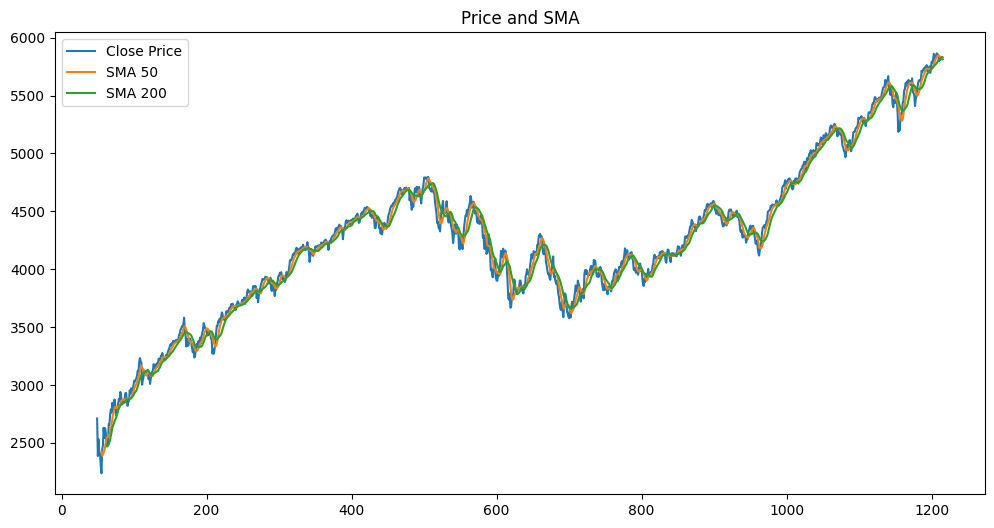

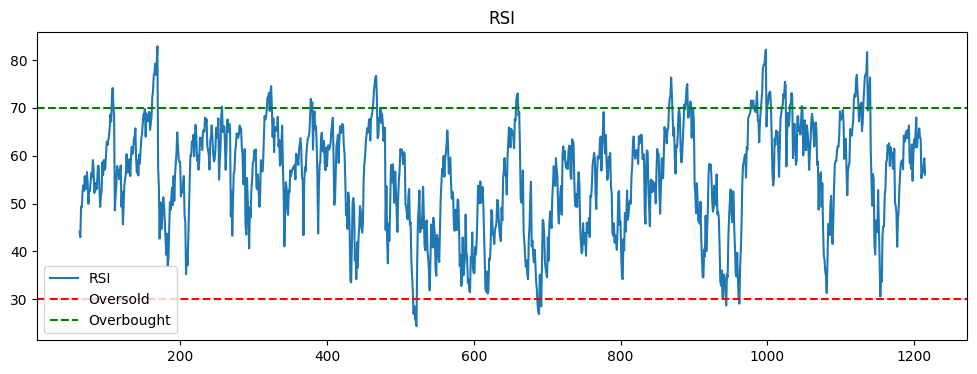

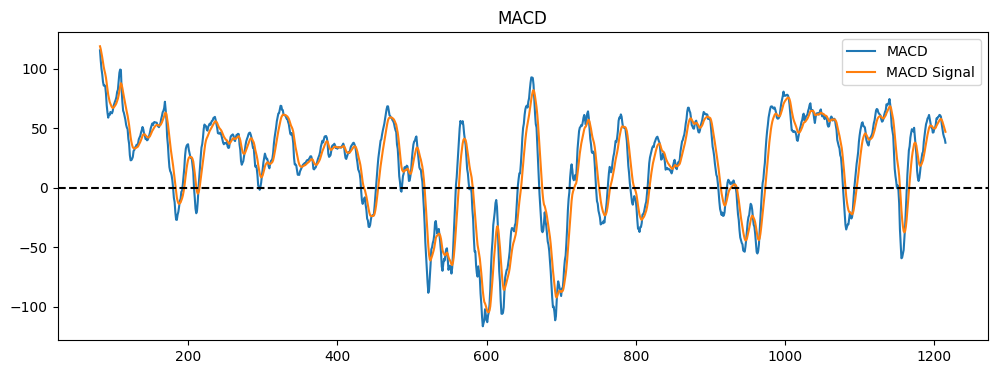

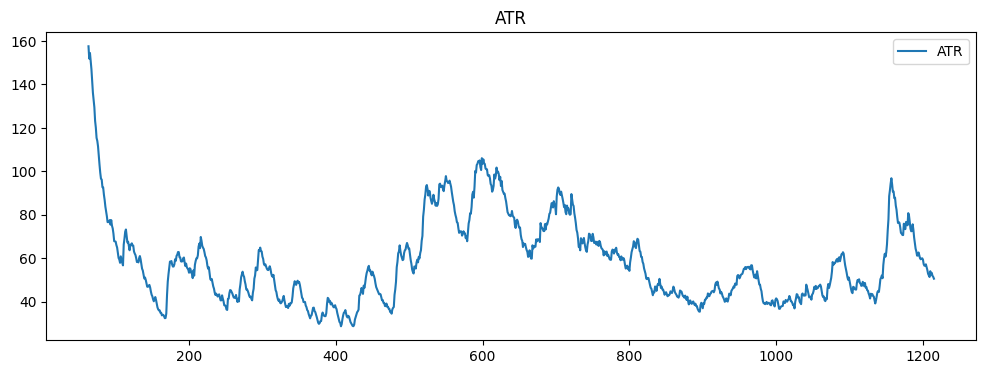

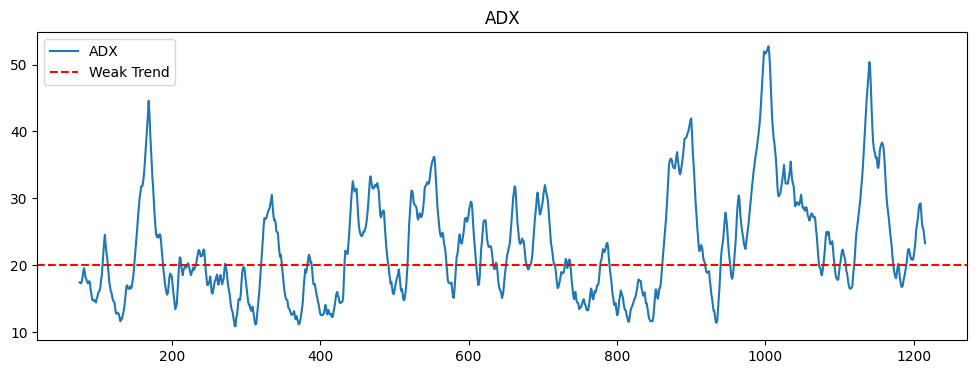

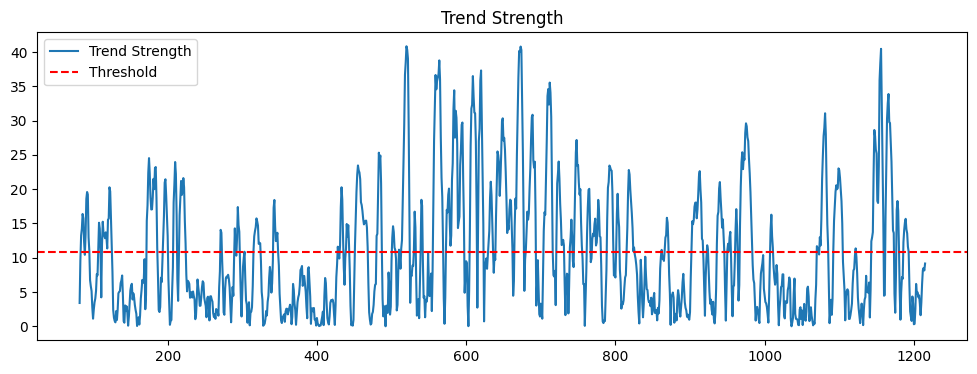

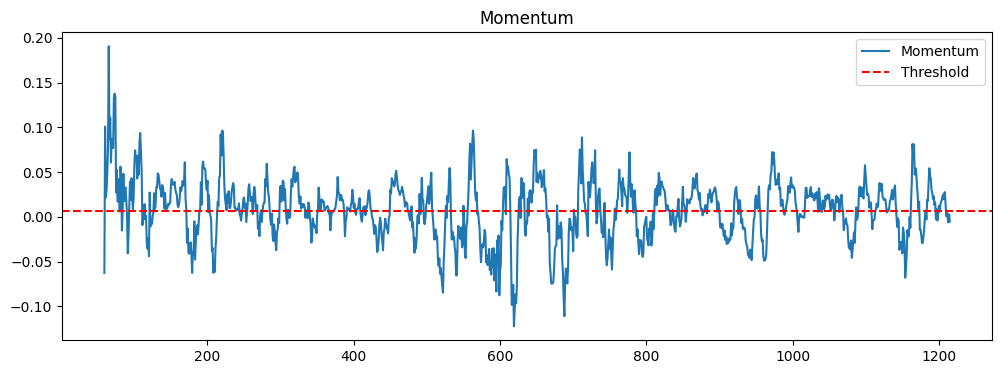

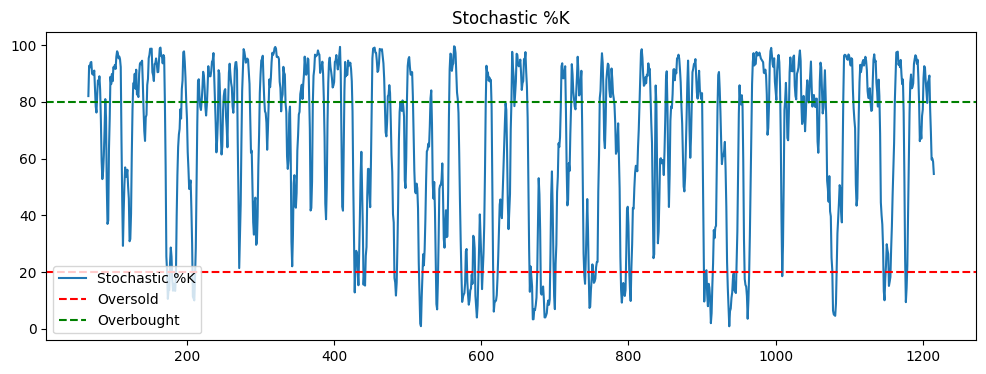

In [169]:
plot_indicators(snp500_data)